In [10]:
import timm
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import cv2

In [11]:
# Create a custom dataset
class VideoDataset(Dataset):
    def __init__(self, video_files, label, transform=None):
        self.video_files = video_files
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        cap = cv2.VideoCapture(self.video_files[idx])
        frames = []
        frame_count = 0
        
        while cap.isOpened() and frame_count < 10:
            ret, frame = cap.read()

            # skip frames on regular intervals, here we set the interal as once in 10 frames
            if frame_count % 10 != 0:
                frame_count += 1
                continue

            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if self.transform:
                frame = self.transform(frame)


            assert frame.shape == (3, 224, 224)
            frames.append(frame)
            frame_count += 1
        cap.release()

        # Pad with zeros if not enough frames
        while len(frames) < 10:
            frames.append(torch.zeros((3, 224, 224)))

        frames = torch.stack(frames)
        # if self.label == 1:
        #     label = torch.ones(frames.shape)
        # else:
        #     label = torch.zeros(frames.shape)
        label = self.label
        return frames, label

# Define your transform
normal_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

mirror_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Define your dataset
positive_video_files = [os.path.join('../ai_golf_swing_dataset/pro_swing_videos', f) for f in sorted(os.listdir('../ai_golf_swing_dataset/pro_swing_videos')) if not f.startswith('.')]  # Add your video file paths
positive_dataset = VideoDataset(positive_video_files, 1, transform=normal_transform)

negative_video_files = [os.path.join('../ai_golf_swing_dataset/amateur_swing_videos', f) for f in sorted(os.listdir('../ai_golf_swing_dataset/amateur_swing_videos')) if not f.startswith('.')]  # Add your video file paths
negative_dataset = VideoDataset(negative_video_files, 0, transform=normal_transform)
negative_mirror_dataset = VideoDataset(negative_video_files, 0, transform=mirror_transform)

# Define your DataLoader
full_dataset = torch.utils.data.ConcatDataset([positive_dataset, negative_dataset, negative_mirror_dataset])

# Split the data into training and validation
# 70% train, 20% dev, 10% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [12]:
class VideoTransformer(nn.Module):
    def __init__(self, vit_model):
        super(VideoTransformer, self).__init__()
        self.vit = vit_model

    def forward(self, x):
        # Reshape input to (batch_size * num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = x.shape
        x = x.view(-1, channels, height, width)
        x = self.vit(x)

        # Reshape output to (batch_size, num_frames, output_dim) and average over frames
        output_dim = x.shape[-1]
        x = x.view(batch_size, num_frames, output_dim)
        x = x.mean(dim=1)

        return x
    
# Create a Vision Transformer model
vit_model = models.vit_b_16(pretrained=True)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, out_features=1)

# Wrap the Vision Transformer model in the VideoTransformer
model = VideoTransformer(vit_model)

# Define your loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train-0: 100%|██████████| 1723/1723 [1:58:16<00:00,  4.12s/it] 


Epoch:  0 Training Loss:  1241.403088176623
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 492/492 [10:53<00:00,  1.33s/it]

Dev Set Acc:  0.4247967479674797
Dev Set F1 score:  0.0


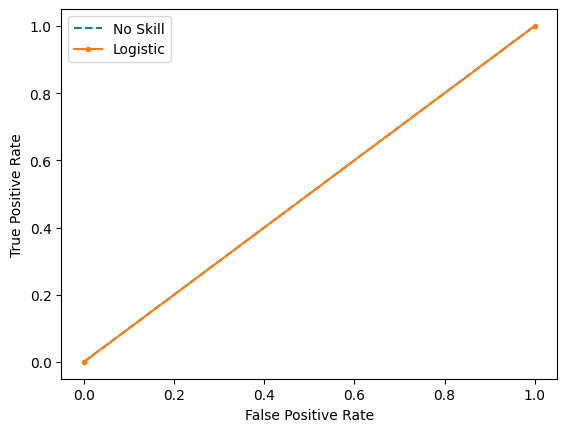

AUC: 0.500


train-1: 100%|██████████| 1723/1723 [1:57:10<00:00,  4.08s/it]


Epoch:  1 Training Loss:  1203.8200616464019
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 492/492 [11:09<00:00,  1.36s/it]

Dev Set Acc:  0.5752032520325203
Dev Set F1 score:  0.7303225806451613


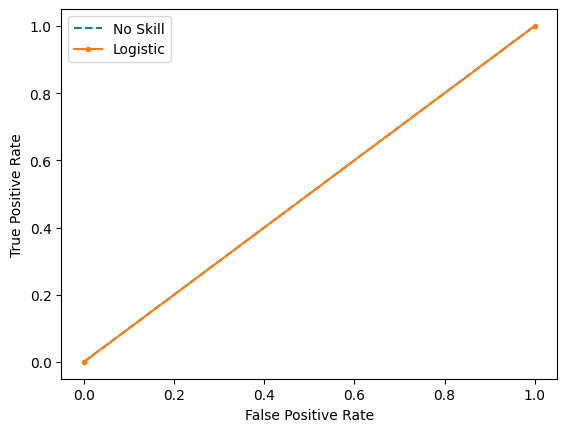

AUC: 0.500


train-2: 100%|██████████| 1723/1723 [2:00:26<00:00,  4.19s/it] 


Epoch:  2 Training Loss:  1189.0314658880234
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 492/492 [11:12<00:00,  1.37s/it]

Dev Set Acc:  0.5752032520325203
Dev Set F1 score:  0.7303225806451613


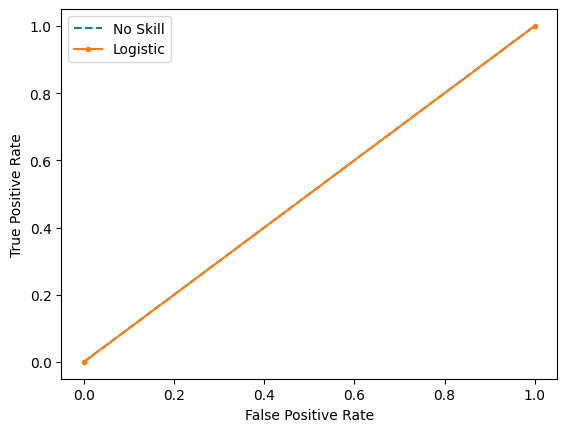

AUC: 0.500


train-3: 100%|██████████| 1723/1723 [1:57:50<00:00,  4.10s/it]


Epoch:  3 Training Loss:  1189.566642433405
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 492/492 [11:01<00:00,  1.34s/it]

Dev Set Acc:  0.5752032520325203
Dev Set F1 score:  0.7303225806451613


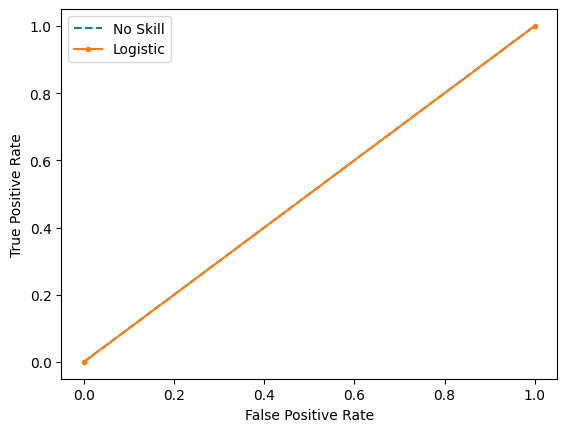

AUC: 0.500


train-4: 100%|██████████| 1723/1723 [1:58:41<00:00,  4.13s/it] 


Epoch:  4 Training Loss:  1189.6397140920162
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 492/492 [11:05<00:00,  1.35s/it]

Dev Set Acc:  0.5752032520325203
Dev Set F1 score:  0.7303225806451613


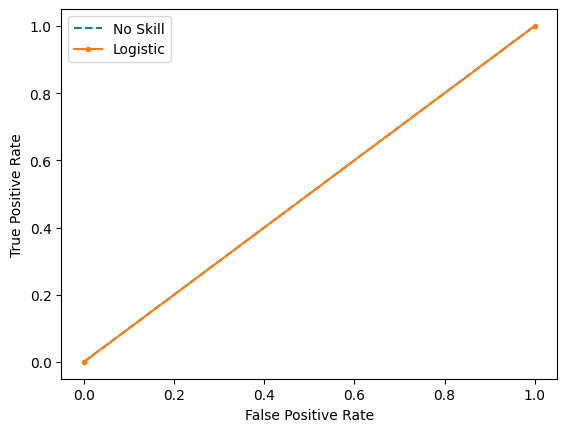

AUC: 0.500
Overall Best Dev Acc:  0.5752032520325203


In [13]:
best_dev_acc = 0.0
best_model = None

TRAINING_EPOCH = 5
# threshold probs for classifier to predict true
threshold = 0.5

# Train the model
training_loss_history = []
training_acc_list = []
val_acc_list = []

for epoch in range(TRAINING_EPOCH):
    model.train()
    train_loss = 0.0
    y_train_true = []
    y_train_pred = []
    for inputs, labels in tqdm(train_dataloader, desc=f'train-{epoch}', disable=False):
        # The inputs here is a batch of videos, each represented as a 3D tensor (num_frames x height x width)
        # We want to reshape it to a 4D tensor (num_frames x num_channels x height x width) 
        # inputs = inputs.transpose(1, 3).to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().reshape(labels.shape)
        y_train_true.extend(labels.tolist())
        y_train_pred.extend(preds.tolist())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_acc = accuracy_score(y_train_true, y_train_pred)
    training_loss_history.append(train_loss)
    training_acc_list.append(train_acc)
    print('Epoch: ', epoch, 'Training Loss: ', train_loss)
    print('Finishing Training the model. Now starting to evaluate...')

    # Validate the model
    model.eval()  # Set the model to evaluation mode

    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc=f'validation', disable=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).int().reshape(labels.shape)
            y_val_true.extend(labels.tolist())
            y_val_pred.extend(preds.tolist())

    f1 = f1_score(y_val_true, y_val_pred, average='binary')
    val_acc = accuracy_score(y_val_true, y_val_pred)
    val_acc_list.append(val_acc)

    print('Dev Set Acc: ', val_acc)
    print('Dev Set F1 score: ', f1)

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)

    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # compute AUC score
    auc = roc_auc_score(y_val_true, y_val_pred)
    print('AUC: %.3f' % auc)

    if val_acc > best_dev_acc:
        best_dev_acc = val_acc
        best_model = 'vit_classifier_epoch_{}.pth'.format(epoch)
        # Save the curr best model
        torch.save(model.state_dict(), best_model)

print('Overall Best Dev Acc: ', best_dev_acc)



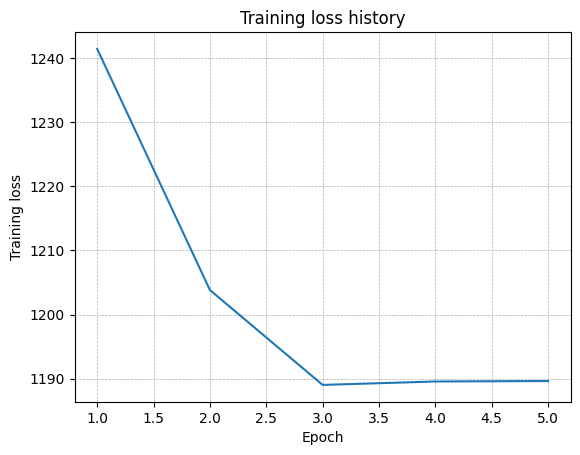

In [14]:
# TODO: training loss vs. epoch curve
plt.plot(list(range(1, 6)), training_loss_history)
plt.title("Training loss history")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

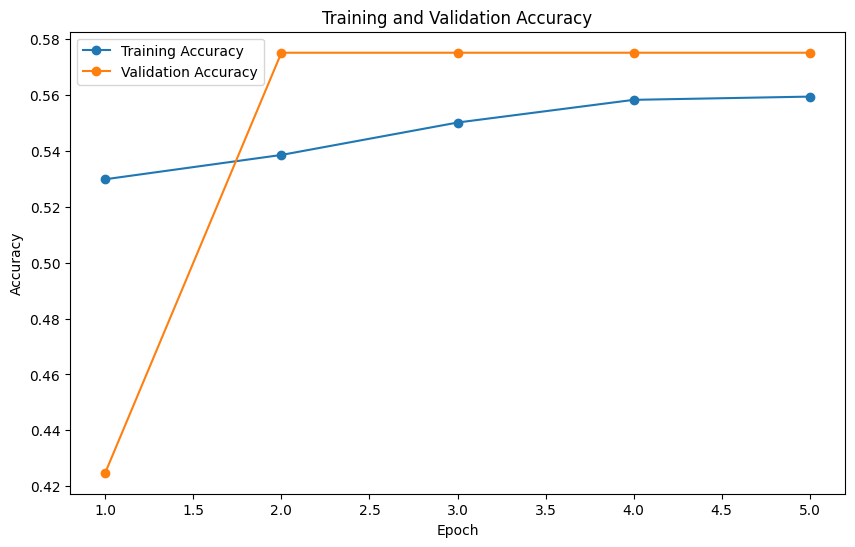

In [15]:
# TODO: training acc + dev set acc vs. epoch
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(list(range(1, 6)), training_acc_list, label='Training Accuracy', marker='o')

# Plot validation accuracy
plt.plot(list(range(1, 6)), val_acc_list, label='Validation Accuracy', marker='o')

# Label axes and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()

In [17]:
# test set validation
print('Starting to evaluate test set...')

print('Loading existing best model ', best_model)

# Load pre-trained model
model = VideoTransformer(vit_model)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
# model.fc = nn.Linear(model.fc.in_features, 1)
# num_features = model.classifier.in_features
# model.classifier = nn.Linear(num_features, 1)

model.load_state_dict(torch.load(best_model))
model.to(device)
model.eval()  # Set the model to evaluation mode

# threshold probs for classifier to predict true
threshold = 0.5

y_val_true = []
y_val_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f'test', disable=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().reshape(labels.shape)
        y_val_true.extend(labels.tolist())
        y_val_pred.extend(preds.tolist())

    print('Test set accuracy: ', accuracy_score(y_val_true, y_val_pred))

Starting to evaluate test set...
Loading existing best model  vit_classifier_epoch_1.pth


test: 100%|██████████| 247/247 [05:36<00:00,  1.36s/it]

Test set accuracy:  0.6437246963562753
